In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import re
import math

import folium

from sklearn.model_selection import train_test_split

from sklearn.multioutput import MultiOutputRegressor

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression,Lasso,Ridge,RANSACRegressor

from sklearn.metrics import r2_score,mean_squared_error

from boruta import BorutaPy

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)

# Functions

In [2]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the Haversine distance between two points given their latitude and longitude in degrees.
    """
    R = 6371  # Radius of the Earth in kilometers

    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))

    # Distance in kilometers
    distance = R * c

    return distance

# Data Load

In [3]:
# loading the data
df = pd.read_csv('../data/train.csv')
df.columns = [label.lower() for label in df.columns]
df.head()

,trip_id,call_type,origin_call,origin_stand,taxi_id,timestamp,day_type,missing_data,polyline
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


## Data Dimension

In [4]:
print('Number of rows: {}\nNumber of columns: {}'.format(df.shape[0], df.shape[1]))

Number of rows: 1710670
Number of columns: 9


## Nan Values

In [5]:
100*df.isna().sum()/df.shape[0]

trip_id          0.000000
call_type        0.000000
origin_call     78.676776
origin_stand    52.850111
taxi_id          0.000000
timestamp        0.000000
day_type         0.000000
missing_data     0.000000
polyline         0.000000
dtype: float64

## Data Types

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710670 entries, 0 to 1710669
Data columns (total 9 columns):
 #   Column        Dtype  
---  ------        -----  
 0   trip_id       int64  
 1   call_type     object 
 2   origin_call   float64
 3   origin_stand  float64
 4   taxi_id       int64  
 5   timestamp     int64  
 6   day_type      object 
 7   missing_data  bool   
 8   polyline      object 
dtypes: bool(1), float64(2), int64(3), object(3)
memory usage: 106.0+ MB


# Data Filtering

In [7]:
# verify if we have None init lat/long
df['polyline'].str[:2].unique()

array(['[[', '[]'], dtype=object)

In [8]:
# verify if we have None last lat/long
df['polyline'].str[-2:].unique()

array([']]', '[]'], dtype=object)

In [9]:
# filtering None init/last coordinates
print(df.shape)
df = df.loc[df['polyline'].str[:2] != '[]']
df = df.loc[df['polyline'].str[-2:] != '[]']
print(df.shape)

(1710670, 9)
(1704769, 9)


# Feature Engineering

In [10]:
# change space of origin_stand
df['int_origin_stand'] = 1
df.loc[df['origin_stand'].isna(),'int_origin_stand'] = 0

# change space of origin_call
df['int_origin_call'] = 1
df.loc[df['origin_call'].isna(),'int_origin_call'] = 0

# change space of missing_data
df['int_missing_data'] = 1
df.loc[(df['missing_data'] == False) | (df['missing_data'] == 'False'),
       'int_missing_data'] = 0

In [11]:
# change to UTC date format
df['date'] = pd.to_datetime(df['timestamp'], unit='s', utc=True)

# just keep YYYY-MM-DD
df['date2'] = pd.to_datetime(df['date'].astype(str).str[:10],format = '%Y-%m-%d')

In [12]:
# create other variables based on datetime
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.day_of_week
df['week_of_year'] = df['date'].dt.weekofyear

In [13]:
# iteration to get the first and last coordinates from all trajectory
vetor_coord = df['polyline'].values
lat_init = []
lat_end = []
long_init = []
long_end = []

for i in vetor_coord:
    string_vetor = re.sub(r'[\[\]\|]', '', i)
    lat_init.append(string_vetor.split(',')[1])
    lat_end.append(string_vetor.split(',')[-1])
    long_init.append(string_vetor.split(',')[0])
    long_end.append(string_vetor.split(',')[-2])


df['lat_init'] = lat_init
df['long_init'] = long_init
df['lat_end'] = lat_end
df['long_end'] = long_end
for i in ['lat_init','lat_end','long_init','long_end']:
    df[i] = df[i].astype(float)

In [14]:
# difference between coordinates
df['diff_long'] = df['long_end'] - df['long_init']
df['diff_lat'] = df['lat_end'] - df['lat_init']

In [15]:
# to save memory
try:
    del lat_init
    del lat_end
    del long_init
    del long_end
    del vetor_coord
except:
    pass

# EDA

In [16]:
df.head(3)

,trip_id,call_type,origin_call,origin_stand,taxi_id,timestamp,day_type,missing_data,polyline,int_origin_stand,int_origin_call,int_missing_data,date,date2,year,month,day,day_of_week,week_of_year,lat_init,long_init,lat_end,long_end,diff_long,diff_lat
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",0,0,0,2013-07-01 00:00:58+00:00,2013-07-01,2013,7,7,0,27,41.141412,-8.618643,41.154489,-8.630838,-0.012195,0.013077
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",1,0,0,2013-07-01 00:08:23+00:00,2013-07-01,2013,7,7,0,27,41.159826,-8.639847,41.170671,-8.665740,-0.025893,0.010845
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",0,0,0,2013-07-01 00:02:31+00:00,2013-07-01,2013,7,7,0,27,41.140359,-8.612964,41.140530,-8.615970,-0.003006,0.000171


### Time series

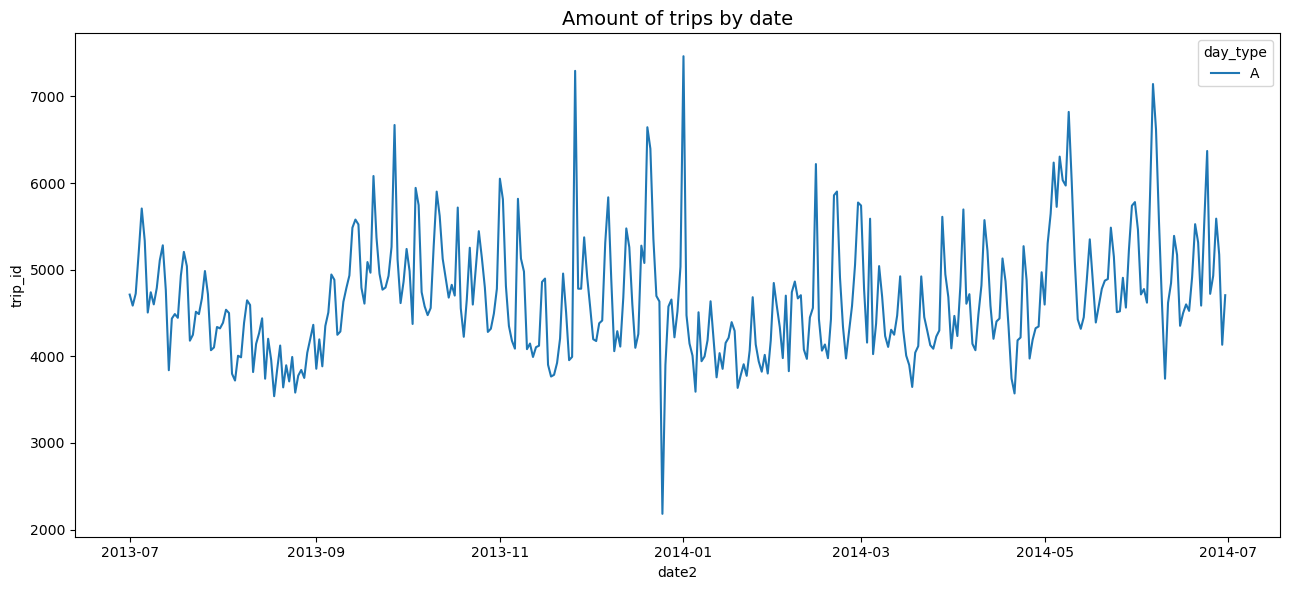

In [17]:

aux = df.groupby(['date2','day_type'],as_index = False)['trip_id'].count()

fig, axes = plt.subplots(1,1,figsize=(13,6))
sns.lineplot(data = aux, x = 'date2',y = 'trip_id',hue = 'day_type', ax = axes);
axes.set_title('Amount of trips by date', fontsize= 14)
plt.tight_layout();

We just have DAY_TYPE = 'A' (normal day) and basically all trips are concentrated between 4000 and 6000

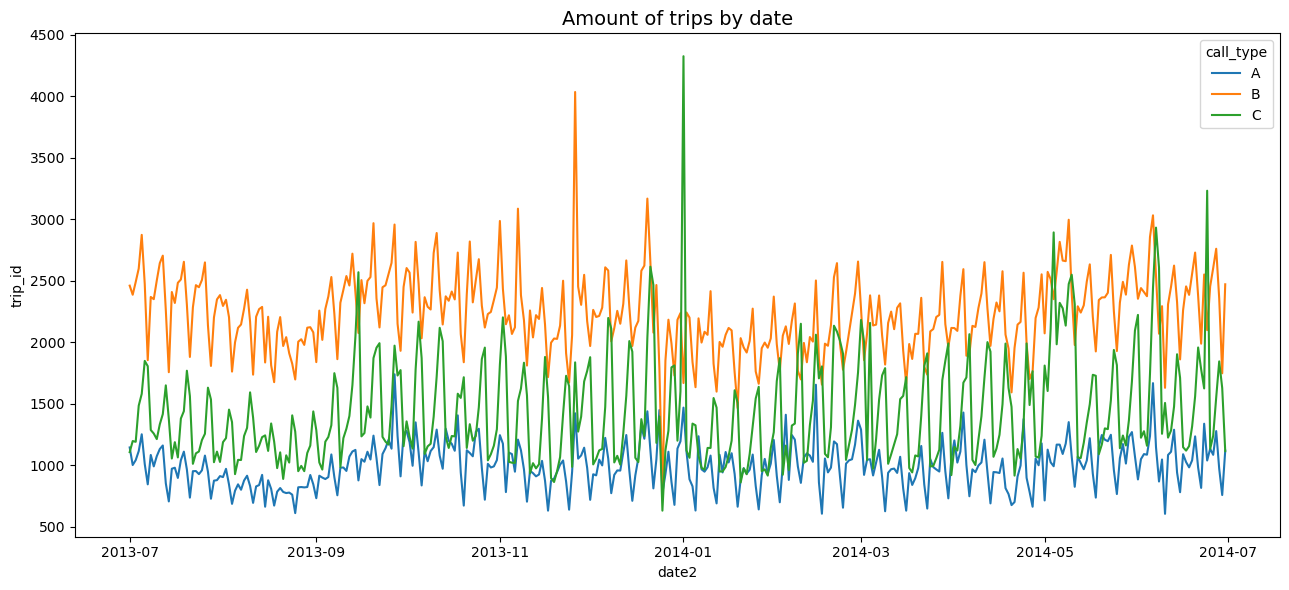

In [18]:
aux = df.groupby(['date2','call_type'],as_index = False)['trip_id'].count()

fig, axes = plt.subplots(1,1,figsize=(13,6))
sns.lineplot(data = aux, x = 'date2',y = 'trip_id',hue = 'call_type', ax = axes);
axes.set_title('Amount of trips by date', fontsize= 14)
plt.tight_layout();

We can see trips created by the dispatched system are the minimum of all data. The majority is concentrated on strated by STAND (B)

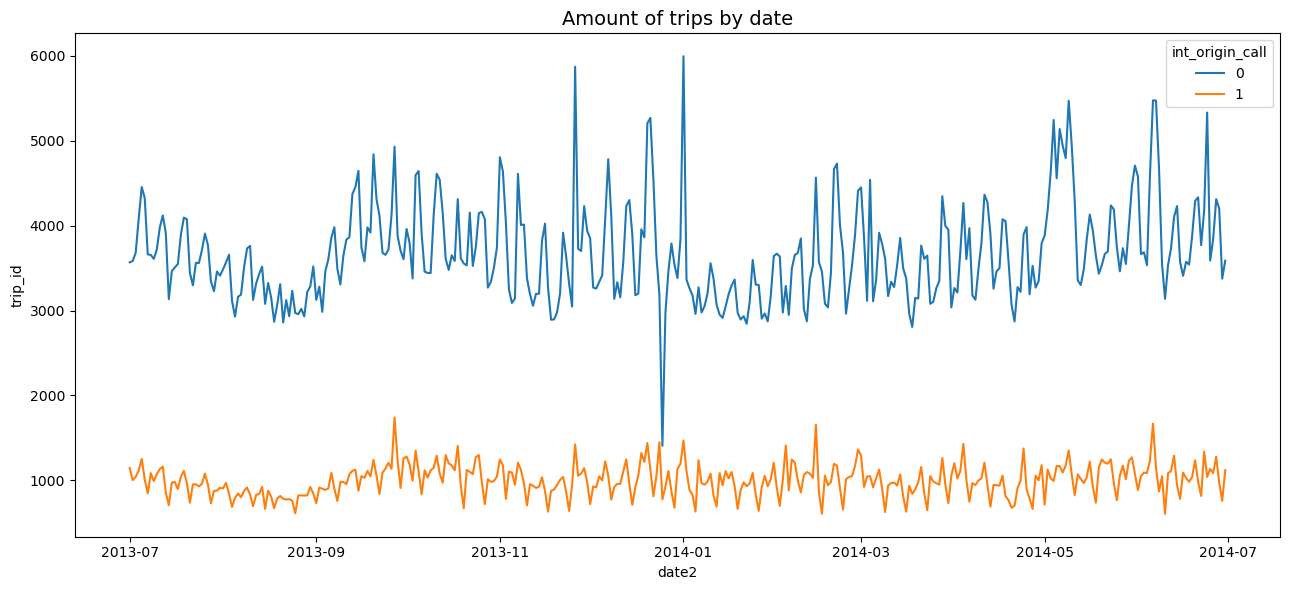

In [19]:
aux = df.groupby(['date2','int_origin_call'],as_index = False)['trip_id'].count()

fig, axes = plt.subplots(1,1,figsize=(13,6))
sns.lineplot(data = aux, x = 'date2',y = 'trip_id',hue = 'int_origin_call', ax = axes);
axes.set_title('Amount of trips by date', fontsize= 14)
plt.tight_layout();

Most trips don't have the ID information of client

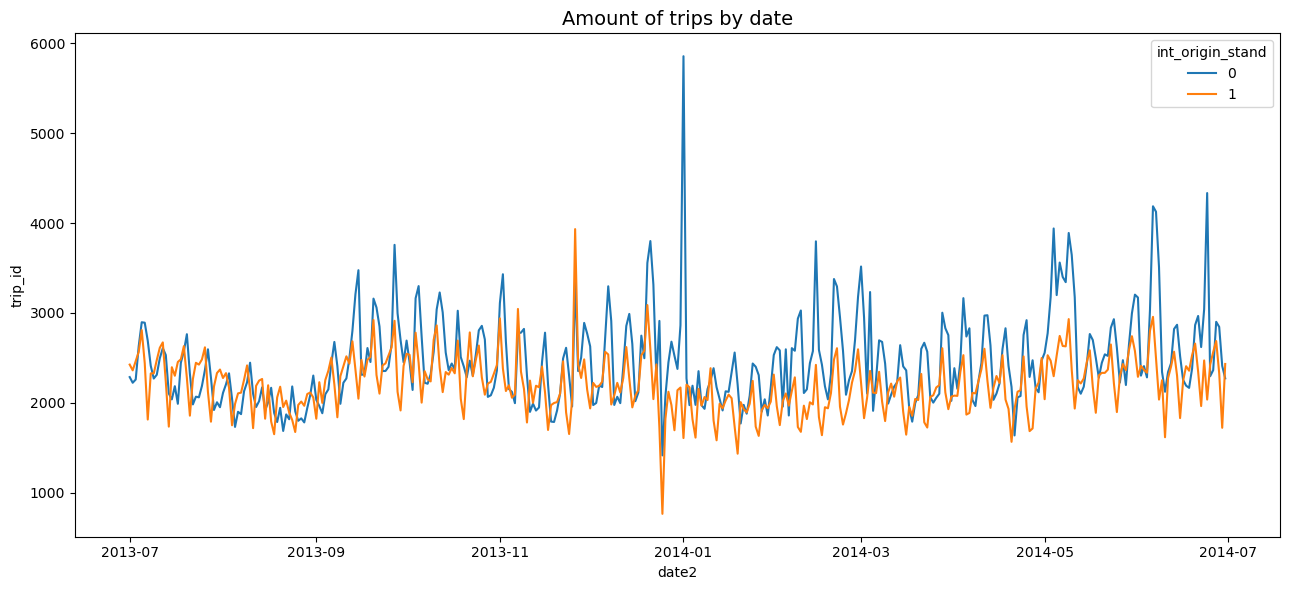

In [20]:
aux = df.groupby(['date2','int_origin_stand'],as_index = False)['trip_id'].count()

fig, axes = plt.subplots(1,1,figsize=(13,6))
sns.lineplot(data = aux, x = 'date2',y = 'trip_id',hue = 'int_origin_stand', ax = axes);
axes.set_title('Amount of trips by date', fontsize= 14)
plt.tight_layout();

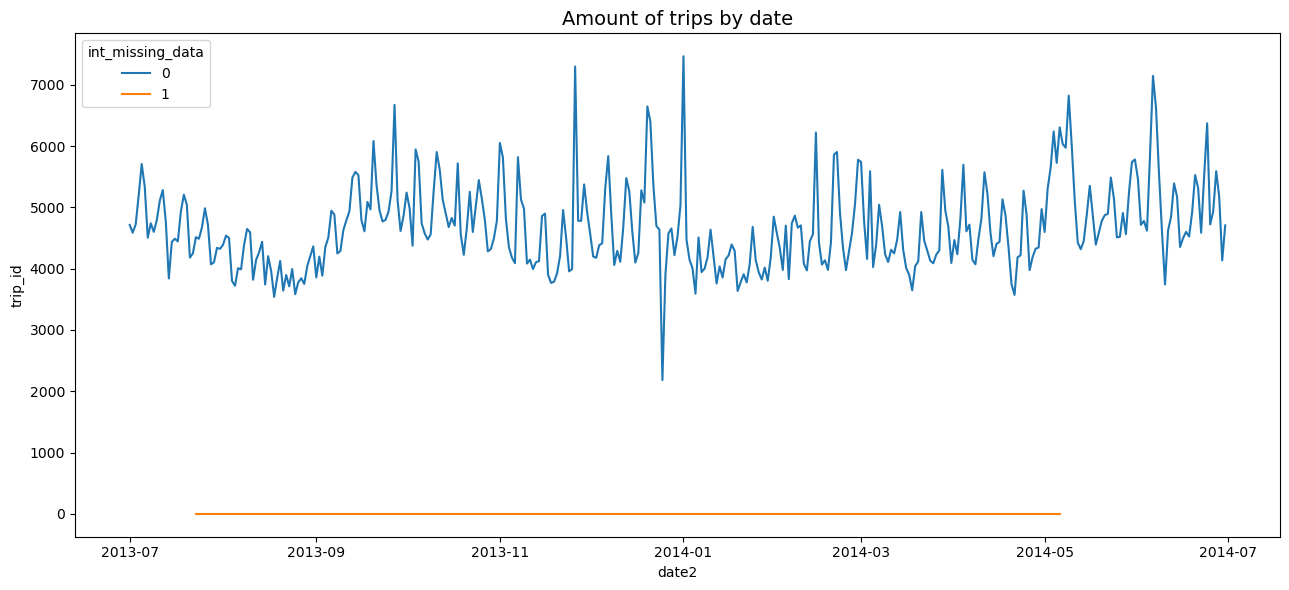

In [21]:
aux = df.groupby(['date2','int_missing_data'],as_index = False)['trip_id'].count()

fig, axes = plt.subplots(1,1,figsize=(13,6))
sns.lineplot(data = aux, x = 'date2',y = 'trip_id',hue = 'int_missing_data', ax = axes);
axes.set_title('Amount of trips by date', fontsize= 14)
plt.tight_layout();

We have just a few trips without coordinates completed

### Category Plot

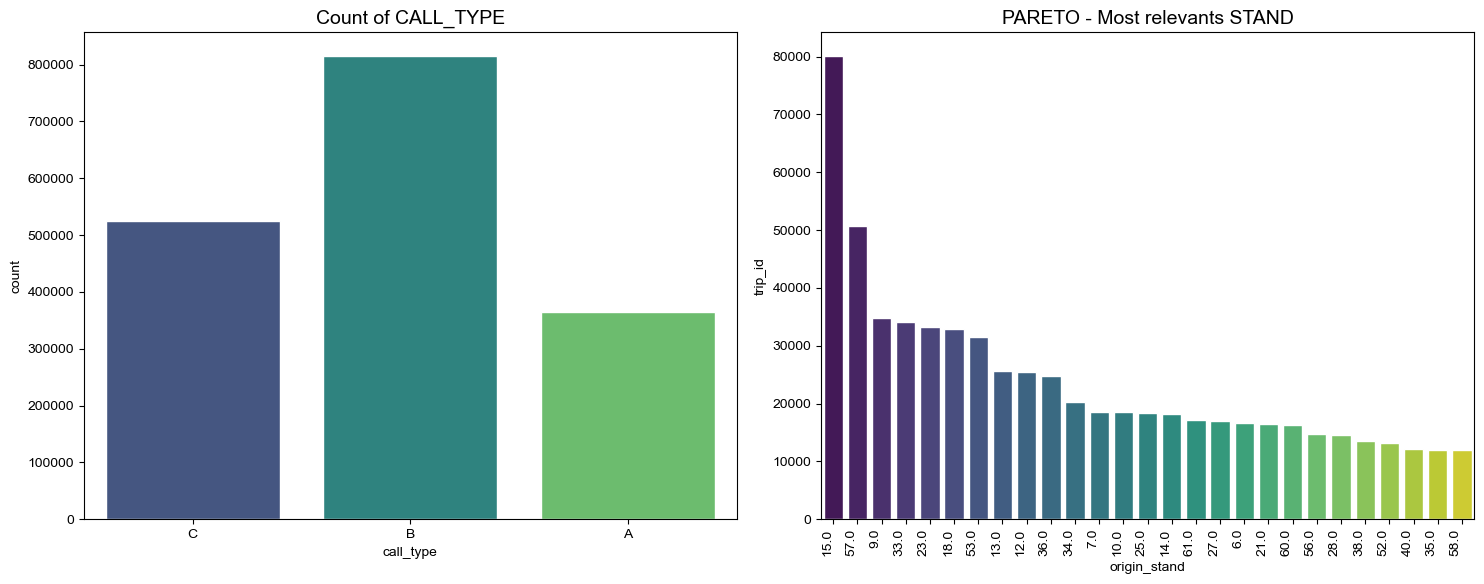

In [22]:
# create a Pareto table
aux = df.groupby(['origin_stand'],as_index = False)['trip_id'].count()
aux = aux.sort_values(by = 'trip_id', ascending = False)
aux['pareto'] = aux['trip_id'].cumsum() / aux['trip_id'].sum()
aux = aux.loc[aux['pareto'] <= 0.8]


fig, axes = plt.subplots(1,2,figsize=(15,6))
sns.set()
sns.countplot(data = df, x = 'call_type', palette='viridis',ax = axes[0]);
axes[0].set_title('Count of CALL_TYPE', fontsize= 14);

sns.barplot(data = aux, x = 'origin_stand',y = 'trip_id', palette='viridis',ax = axes[1], order = aux['origin_stand'].values);
axes[1].set_title('PARETO - Most relevants STAND', fontsize= 14);
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90, ha='right')
plt.tight_layout();

We can see that most trip were occured started in a stand or randomly in street.

The stand 15 and 57 are the most relevants, with more than 50k of trips

80% of all trips are concentrated in 27 stands (of 63 stands)

### Map of stand 57 and 15

Here it is possible to see STAND 57 and 15 are metropolitan locations, near from important roads and railroads

In [23]:
# # is commented to save processing time

# df_15 = df.loc[df['origin_stand'].isin([15]),['lat_init','long_init']].drop_duplicates(subset=['lat_init','long_init'])
# df_57 = df.loc[df['origin_stand'].isin([57]),['lat_init','long_init']].drop_duplicates(subset=['lat_init','long_init'])
# coord_c = [41.1572550114,-8.6170580694]

# mapa = folium.Map(location= coord_c,zoom_start=11)

# la_i = df_15['lat_init'].values
# lo_i = df_15['long_init'].values
# la_e = df_57['lat_init'].values
# lo_e = df_57['long_init'].values
# for i in range(len(la_i)):
#     folium.CircleMarker(location=[la_i[i],lo_i[i]], radius=0.5, color='green',tooltip="STAND 15").add_to(mapa)
# for i in range(len(la_i)):
#     folium.CircleMarker(location=[la_e[i],lo_e[i]], radius=0.5, color='red',tooltip="STAND 57").add_to(mapa)

# mapa.save('../img/mapa_posto_15_e_57.html')

### Map of samples

Here it's possible to see there is a concentration in the downtown area of Porto

In [24]:
# a sample because Folium take time to render
df_folium = df.sample(n = 10000)
avg_lat = df_folium['lat_init'].mean()
avg_long = df_folium['long_init'].mean()
print(avg_lat,avg_long)

41.156713498500004 -8.617528638


In [25]:
# # is commented to save processing time

# mapa = folium.Map(location= [df_folium['lat_init'].mean(),df_folium['long_init'].mean()],zoom_start=10)

# la_i = df_folium['lat_init'].values
# lo_i = df_folium['long_init'].values
# la_e = df_folium['lat_end'].values
# lo_e = df_folium['long_end'].values
# for i in range(len(la_i)):
#     folium.CircleMarker(location=[la_i[i],lo_i[i]], radius=0.5, color='green').add_to(mapa)
# for i in range(len(la_i)):
#     folium.CircleMarker(location=[la_e[i],lo_e[i]], radius=0.5, color='red').add_to(mapa)

# mapa.save('../img/mapa_parcial.html')

### Dispersion in Coordinates

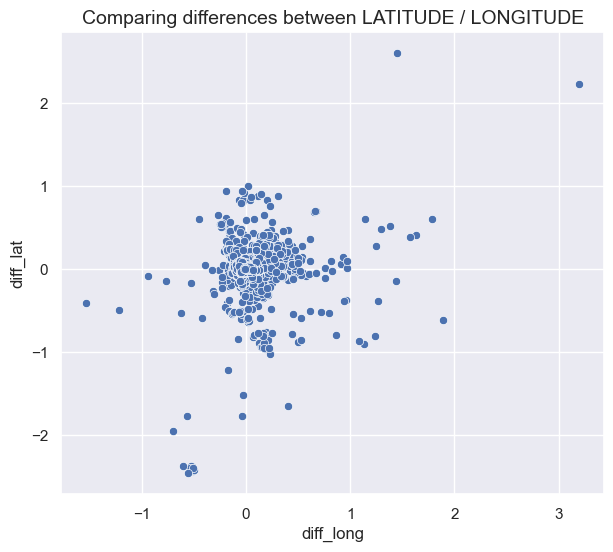

In [26]:
fig, axes = plt.subplots(1,1,figsize = (7,6))

sample = df.sample(n = 200000)
sns.scatterplot(data = sample,x = 'diff_long', y = 'diff_lat', ax = axes);
axes.set_title('Comparing differences between LATITUDE / LONGITUDE', fontsize = 14);

Text(0.5, 1.0, 'Dispersion of LONGITUDE difference')

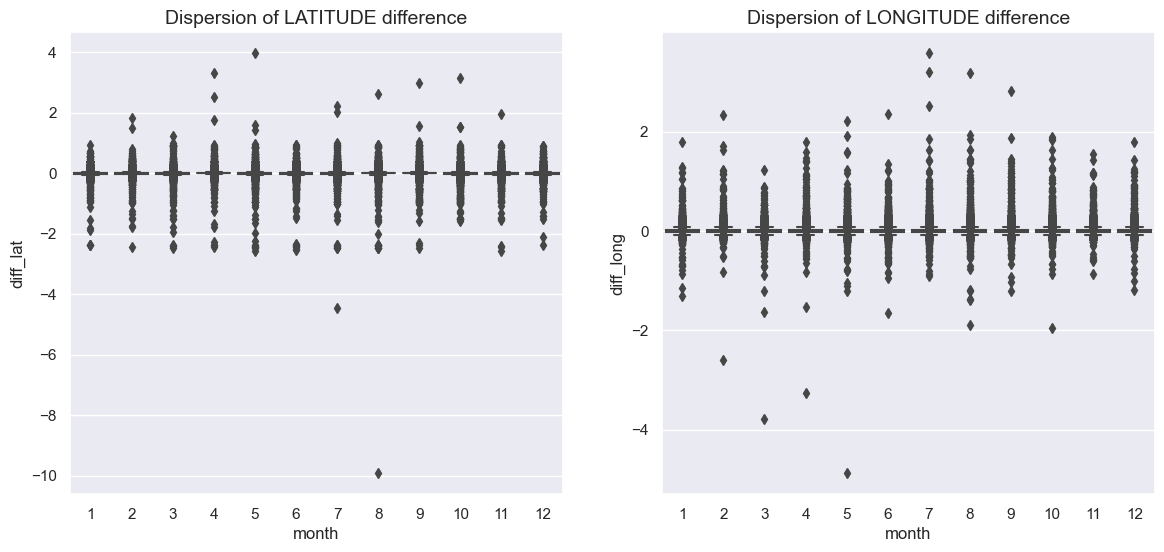

In [27]:
fig, axes = plt.subplots(1,2,figsize = (14,6))

sample = df.sample(n = 50000)
sns.boxplot(data = df,x = 'month', y = 'diff_lat', ax = axes[0]);
sns.boxplot(data = df,x = 'month', y = 'diff_long', ax = axes[1]);
axes[0].set_title('Dispersion of LATITUDE difference', fontsize = 14)
axes[1].set_title('Dispersion of LONGITUDE difference', fontsize = 14)

# Data Preparation

In [28]:
multiply_factor = 1
iqr_lat = df['diff_lat'].quantile(0.75) - df['diff_lat'].quantile(0.25) 
min_lat = multiply_factor * ( df['diff_lat'].quantile(0.25)  - (1.5*iqr_lat) )
max_lat = multiply_factor * ( df['diff_lat'].quantile(0.75)  + (1.5*iqr_lat) )

iqr_long = df['diff_long'].quantile(0.75) - df['diff_long'].quantile(0.25) 
min_long = multiply_factor * ( df['diff_long'].quantile(0.25)  - (1.5*iqr_long) )
max_long = multiply_factor * ( df['diff_long'].quantile(0.75)  + (1.5*iqr_long) )

print(min_lat)
print(min_long)
print(max_lat)
print(max_long)

print(df.shape)
df = df.loc[(df['diff_lat'] >= min_lat) & (df['diff_lat'] <= max_lat) & (df['diff_long'] >= min_long) & (df['diff_long'] <= max_long)]
print(df.shape)

-0.041296499999994296
-0.0820710000000009
0.04729950000000116
0.07532100000000064
(1704769, 25)
(1539238, 25)


In [29]:
df = df.reset_index(drop = True)

In [30]:
# dummies for call_type
df = pd.get_dummies(df,columns=['call_type'],prefix='ct', drop_first=False)

In [31]:
# commented because it not cause a significant change in RMSE
# nature transformation
# I did this because these data are cyclical

# day of week
df['day_of_week_sin'] = df['day_of_week'].apply( lambda x: np.sin( x * (2 * np.pi / 7 ) ) )
df['day_of_week_cos'] = df['day_of_week'].apply( lambda x: np.cos( x * (2 * np.pi / 7 ) ) )

# month
df['month_sin'] = df['month'].apply( lambda x: np.sin( x * (2 * np.pi / 12 ) ) )
df['month_cos'] = df['month'].apply( lambda x: np.cos( x * (2 * np.pi / 12 ) ) )

# day
df['day_sin'] = df['day'].apply( lambda x: np.sin( x * (2 * np.pi / 30 ) ) )
df['day_cos'] = df['day'].apply( lambda x: np.cos( x * (2 * np.pi / 30 ) ) )

# week of year
df['week_of_year_sin'] = df['week_of_year'].apply( lambda x: np.sin( x * (2 * np.pi / 52 ) ) )
df['week_of_year_cos'] = df['week_of_year'].apply( lambda x: np.cos( x * (2 * np.pi / 52 ) ) )

In [32]:
# save to have a checkpoint
# df.to_parquet('../data/train_fe.parquet', index = False)

In [33]:
cols_modelo = ['int_origin_stand', 'int_origin_call', 'int_missing_data','ct_A', 'ct_B','ct_C',
               'day_of_week_sin','day_of_week_cos','month_sin','month_cos','day_sin','day_cos','week_of_year_sin','week_of_year_cos',
               'lat_init','long_init','diff_lat','diff_long','lat_end', 'long_end']

In [34]:
# make my feature dataset and target dataset
X = df[cols_modelo].sample(frac = 0.5)

y = X[['lat_end', 'long_end']]

X = X.drop(['lat_end', 'long_end'], axis = 1)

In [35]:
# split to train/test
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)
print('Train shape: ',X_train.shape)
print('Test shape: ',X_test.shape)

Train shape:  (577214, 18)
Test shape:  (192405, 18)


In [36]:
X_val = df.loc[~df.index.isin(X.index),cols_modelo].drop(['lat_end', 'long_end'], axis = 1)
X_val.shape

(769619, 18)

In [37]:
# make a checkpoint to save memory
X_train.to_parquet('../data/X_train_nat.parquet', index = False)
X_test.to_parquet('../data/X_test_nat.parquet', index = False)
y_train.to_parquet('../data/y_train_nat.parquet', index = False)
y_test.to_parquet('../data/y_test_nat.parquet', index = False)

X_val.to_parquet('../data/X_val_nat.parquet', index = False)

(852385, 10)

# Middle Reading

In [3]:
X_train = pd.read_parquet('../data/X_train_nat.parquet')
X_test = pd.read_parquet('../data/X_test_nat.parquet')
y_train = pd.read_parquet('../data/y_train_nat.parquet')
y_test = pd.read_parquet('../data/y_test_nat.parquet')

# ML Modeling

In [4]:
dr = MultiOutputRegressor(DummyRegressor(strategy='mean'))

dr.fit(X_train, y_train)

yhat_dr = dr.predict(X_test)

r2_dr = r2_score(y_test,yhat_dr)
rmse_dr = np.sqrt(mean_squared_error(y_test,yhat_dr))

print('R2 Score on test: ',r2_dr)
print('RMSE on test: ',rmse_dr)

R2 Score on test:  -8.008989368590846e-06
RMSE on test:  0.03354334804067944


In [5]:
# rfr = MultiOutputRegressor(RandomForestRegressor(n_estimators= 100, n_jobs=-1, random_state=42))

# rfr.fit(X_train, y_train)

# yhat_rfr = rfr.predict(X_test)

# r2_rfr = r2_score(y_test,yhat_rfr)
# rmse_rfr = np.sqrt(mean_squared_error(y_test,yhat_rfr))

# print('R2 Score on test: ',r2_rfr)
# print('RMSE on test: ',rmse_rfr)

In [6]:
xgbr = MultiOutputRegressor(XGBRegressor(objective = 'reg:squarederror',n_estimators= 100, n_jobs=-1, random_state=42))

xgbr.fit(X_train, y_train)

yhat_xgbr = xgbr.predict(X_test)

r2_xgbr = r2_score(y_test,yhat_xgbr)
rmse_xgbr = np.sqrt(mean_squared_error(y_test,yhat_xgbr))

print('R2 Score on test: ',r2_xgbr)
print('RMSE on test: ',rmse_xgbr)

In [ ]:
lr = MultiOutputRegressor(LinearRegression(n_jobs=-1))

lr.fit(X_train, y_train)

yhat_lr = lr.predict(X_test)

r2_lr = r2_score(y_test,yhat_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test,yhat_lr))

print('R2 Score on test: ',r2_lr)
print('RMSE on test: ',rmse_lr)

R2 Score on test:  1.0
RMSE on test:  2.0104349247810017e-14


In [ ]:
lasso = MultiOutputRegressor(Lasso(alpha = 5, random_state=42))

lasso.fit(X_train, y_train)

yhat_lasso = lasso.predict(X_test)

r2_lasso = r2_score(y_test,yhat_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test,yhat_lasso))

print('R2 Score on test: ',r2_lasso)
print('RMSE on test: ',rmse_lasso)

R2 Score on test:  -3.7082027749546498e-06
RMSE on test:  0.040068952228851006


In [ ]:
ridge = MultiOutputRegressor(Ridge(alpha = 20,max_iter=1000, random_state=42))

ridge.fit(X_train, y_train)

yhat_ridge = ridge.predict(X_test)

r2_ridge = r2_score(y_test,yhat_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test,yhat_ridge))

print('R2 Score on test: ',r2_ridge)
print('RMSE on test: ',rmse_ridge)

R2 Score on test:  0.998474733988988
RMSE on test:  0.001458260516648065


In [ ]:
ransac = MultiOutputRegressor(RANSACRegressor(random_state=42))

ransac.fit(X_train, y_train)

yhat_ransac = ransac.predict(X_test)

r2_ransac = r2_score(y_test,yhat_ransac)
rmse_ransac = np.sqrt(mean_squared_error(y_test,yhat_ransac))

print('R2 Score on test: ',r2_ransac)
print('RMSE on test: ',rmse_ransac)

R2 Score on test:  1.0
RMSE on test:  4.637644490756912e-12


In [ ]:
# IQR padrao, com transformação de natureza
final_rmse = pd.DataFrame([
    ['Dummy',rmse_dr,r2_dr],
     ['XGB',rmse_xgbr,r2_xgbr],
     ['LinearReg',rmse_lr,r2_lr],
     ['Lasso',rmse_lasso,r2_lasso],
     ['Ridge',rmse_ridge,r2_ridge],
     ['RANSAC',rmse_ransac,r2_ransac]
     ], columns=['Model','RMSE', 'R2'])
final_rmse.sort_values('RMSE')

,Model,RMSE
2,LinearReg,2.010435e-14
5,RANSAC,4.637644e-12
4,Ridge,1.458261e-03
1,XGB,1.357741e-02
0,Dummy,4.006895e-02
3,Lasso,4.006895e-02


In [ ]:
# # coeficients
# lr.estimators_[0].coef_
# lr.estimators_[0].intercept_

# Business Performance

In [15]:
df_test = pd.read_csv('../data/test.csv')
df_test.columns = [label.lower() for label in df_test.columns]

print(df_test.shape)
df_test = df_test.loc[df_test['polyline'].str[:2] != '[]']
df_test = df_test.loc[df_test['polyline'].str[-2:] != '[]']
print(df_test.shape)

# change space of origin_stand
df_test['int_origin_stand'] = 1
df_test.loc[df_test['origin_stand'].isna(),'int_origin_stand'] = 0

# change space of origin_call
df_test['int_origin_call'] = 1
df_test.loc[df_test['origin_call'].isna(),'int_origin_call'] = 0


# change space of missing_data
df_test['int_missing_data'] = 1
df_test.loc[(df_test['missing_data'] == False) | (df_test['missing_data'] == 'False'),'int_missing_data'] = 0


vetor_coord = df_test['polyline'].values
lat_init = []
lat_end = []
long_init = []
long_end = []

for i in vetor_coord:
    string_vetor = re.sub(r'[\[\]\|]', '', i)
    lat_init.append(string_vetor.split(',')[1])
    lat_end.append(string_vetor.split(',')[-1])
    long_init.append(string_vetor.split(',')[0])
    long_end.append(string_vetor.split(',')[-2])


df_test['lat_init'] = lat_init
df_test['long_init'] = long_init
df_test['lat_end'] = lat_end
df_test['long_end'] = long_end
for i in ['lat_init','lat_end','long_init','long_end']:
    df_test[i] = df_test[i].astype(float)

# difference between coordinates
df_test['diff_long'] = df_test['long_end'] - df_test['long_init']
df_test['diff_lat'] = df_test['lat_end'] - df_test['lat_init']


# dummies for call_type
df_test = pd.get_dummies(df_test,columns=['call_type'],prefix='ct', drop_first=False)

X_df_test = df_test[cols_modelo].drop(['lat_end','long_end'], axis = 1)

(320, 9)
(320, 9)


In [16]:
yhat_test = lr.predict(X_df_test)
yhat_dummy = dr.predict(X_df_test)

In [17]:
df_test[['lat_model','long_model']] = yhat_test
df_test[['lat_dummy','long_dummy']] = yhat_dummy

df_test['real_distances'] = df_test.apply(lambda x: haversine_distance(x['lat_init'], x['long_init'], x['lat_end'], x['long_end']), axis = 1)
df_test['model_distances'] = df_test.apply(lambda x: haversine_distance(x['lat_init'], x['long_init'], x['lat_model'], x['long_model']), axis = 1)
df_test['dummy_distances'] = df_test.apply(lambda x: haversine_distance(x['lat_init'], x['long_init'], x['lat_dummy'], x['long_dummy']), axis = 1)

In [18]:
df_test.head()

,trip_id,origin_call,origin_stand,taxi_id,timestamp,day_type,missing_data,polyline,int_origin_stand,int_origin_call,int_missing_data,lat_init,long_init,lat_end,long_end,diff_long,diff_lat,ct_A,ct_B,ct_C,lat_model,long_model,lat_dummy,long_dummy,real_distances,model_distances,dummy_distances
0,T1,NaN,15.0,20000542,1408039037,A,False,"[[-8.585676,41.148522],[-8.585712,41.148639],[...",1,0,0,41.148522,-8.585676,41.146623,-8.584884,0.000792,-0.001899,0,1,0,41.146623,-8.584884,41.158656,-8.618954,0.221328,0.221328,3.005402
1,T2,NaN,57.0,20000108,1408038611,A,False,"[[-8.610876,41.14557],[-8.610858,41.145579],[-...",1,0,0,41.145570,-8.610876,41.163597,-8.601894,0.008982,0.018027,0,1,0,41.163597,-8.601894,41.158656,-8.618954,2.140926,2.140926,1.604572
2,T3,NaN,15.0,20000370,1408038568,A,False,"[[-8.585739,41.148558],[-8.58573,41.148828],[-...",1,0,0,41.148558,-8.585739,41.167719,-8.574903,0.010836,0.019161,0,1,0,41.167719,-8.574903,41.158656,-8.618954,2.315694,2.315694,2.999011
3,T4,NaN,53.0,20000492,1408039090,A,False,"[[-8.613963,41.141169],[-8.614125,41.141124],[...",1,0,0,41.141169,-8.613963,41.140980,-8.614638,-0.000675,-0.000189,0,1,0,41.140980,-8.614638,41.158656,-8.618954,0.060305,0.060305,1.988835
4,T5,NaN,18.0,20000621,1408039177,A,False,"[[-8.619903,41.148036],[-8.619894,41.148036]]",1,0,0,41.148036,-8.619903,41.148036,-8.619894,0.000009,0.000000,0,1,0,41.148036,-8.619894,41.158656,-8.618954,0.000754,0.000754,1.183531


In [20]:
melhor_cenario = np.mean(df_test['real_distances'] - df_test['model_distances'])
pior_cenario = np.mean(df_test['real_distances'] - df_test['dummy_distances'])
print('Melhor cenario:',melhor_cenario)
print('Pior cenario:',pior_cenario)

Melhor cenario: -7.28968160231585e-14
Pior cenario: 0.2964386537336293


In [1]:
real = df_test['real_distances'].sum()
predito = df_test['model_distances'].sum()
dummy = df_test['dummy_distances'].sum()

melhor_cenario = predito - real
pior_cenario = dummy - real
print(melhor_cenario)
print(pior_cenario)

NameError: name 'df_test' is not defined

In [ ]:
submit = pd.DataFrame({"TRIP_ID":df_test['trip_id'].values, "LATITUDE":df_test['lat_model'].values, "LONGITUDE":df_test['long_model'].values})
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv("./submission.csv")
sub.head(5)

,TRIP_ID,LATITUDE,LONGITUDE
0,T1,41.146623,-8.584884
1,T2,41.163597,-8.601894
2,T3,41.167719,-8.574903
3,T4,41.140980,-8.614638
4,T5,41.148036,-8.619894


In [ ]:
sub.shape

(320, 3)